In [1]:
import torch
from PIL import Image
import torchvision
import numpy as np
from detection_transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotate, RandomResize, Compose, ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn
from data import BedsoreDataset,BedsoreDataModule
from utils import batch2pil

### 暂时保留可能有用

In [2]:
net = maskrcnn_resnet50_fpn(pretrained=True)
in_features = net.roi_heads.box_predictor.cls_score.in_features
net.roi_heads.box_predictor = FastRCNNPredictor(in_features, 7)

In [3]:
tfmc_train = Compose([ToTensor()])
ds = BedsoreDataset('data', transforms=tfmc_train)
image,target = ds[4]

In [4]:
target

{'boxes': tensor([[ 28.2734, 129.2988, 371.7831, 320.7009],
         [227.0000, 197.0000, 288.0000, 245.0000],
         [ 70.0000, 187.0000, 163.0000, 265.0000],
         [189.0000, 220.0000, 229.0000, 258.0000]]),
 'labels': tensor([5, 8, 7, 7]),
 'image_id': tensor([4]),
 'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0.,

In [3]:
%debug

> /home/zrway/Projects/Bedsore/data.py(70)__getitem__()
     68 
     69         masks = torchvision.transforms.ToTensor()(masks)
---> 70         masks = torch.cat((pre_masks,masks),dim=0)
     71         target['masks'] = masks
     72         import ipdb; ipdb.set_trace()



ipdb>  pre_masks.shape


torch.Size([1, 424, 414])


ipdb>  masks.shape


torch.Size([414, 3, 424])


ipdb>  masks.shape


torch.Size([414, 3, 424])


ipdb>  q


In [17]:
net([image],[target])

/home/zrway/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


{'loss_classifier': tensor(2.0093, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.0623, grad_fn=<DivBackward0>),
 'loss_mask': tensor(0.4225, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_objectness': tensor(0.0339, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0044, grad_fn=<DivBackward0>)}

In [9]:
dm = BedsoreDataModule('data', 1)
dm.setup()

In [10]:
test_x  = next(iter(dm.val_dataloader()))[0]

In [1]:
from model import MyFasterRCNN

In [2]:
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/a3c2e29391714b9a8fa06defdba070f7/checkpoints/epoch=17.ckpt')

In [6]:
net = model.net
net.eval()
pass

In [12]:
out = net(test_x)

/home/zrway/anaconda3/lib/python3.7/site-packages/torchvision/ops/poolers.py:216: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_in_level = torch.nonzero(levels == level).squeeze(1)


In [48]:
mask = out[0]['masks'][0]

In [ ]:
torchvision.transforms.ToPILImage()((mask>0).float())

In [60]:
out[0]['masks'].max()

tensor(0.1052, grad_fn=<MaxBackward1>)

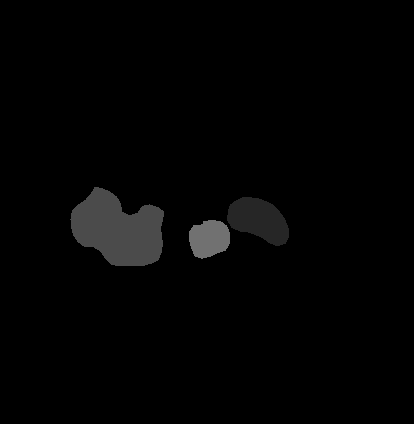

In [14]:
mask = Image.open('data/VOCdevkit/VOC2007/SegmentationObject/B01_00007.png').convert('L')
mask

In [19]:
mask = np.array(mask)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [21]:
obj_ids = np.unique(mask)[1:]
obj_ids

array([ 38,  75, 113], dtype=uint8)

In [22]:
masks = mask == obj_ids[:, None, None]

In [62]:
mask_cls = Image.open('data/VOCdevkit/VOC2007/SegmentationClass/B01_00007.png').convert('L')
mask_cls = np.array(mask_cls)
obj_ids = np.unique(mask_cls)[1:]
obj_ids

array([137, 173], dtype=uint8)

In [67]:
mask_clas = masks * mask_cls

In [84]:
mask_clas[0].max()

173

In [97]:
mask_clas.max(1).max(1)

array([173, 137, 137], dtype=uint8)

In [4]:
a = [132,43]

In [5]:
a == 132

False

### Load checkpoint and plot

In [5]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
import os
from PIL import Image
import numpy as np

In [6]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1, trans_prob=0.5)
ds = dm.val_dataloader().dataset
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/d943453c13254916a4bc0765d150437f/checkpoints/epoch=21.ckpt')
net = model.net
net.eval()
pass

/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning


AttributeError: Missing attribute "train_layers"

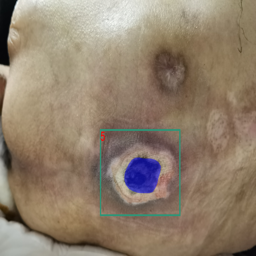

In [7]:
idx = 1
image,target = ds[idx]
# out = net([image],[target])[0]
# print(target['fname'])
# print('gt:',target['labels'])
# print('out labels: ', out['labels'])
# print('out scores: ', out['scores'].detach())

# good_labels = out['labels'][out['scores']>0.5]
# good_masks = out['masks'][out['scores']>0.5][good_labels>6]
# good_labels = good_labels[good_labels>6]
# print('tissue:',good_labels, good_masks.shape)


draw_bbox(image,target).resize((256,256))

In [4]:
%debug

> /home/zrway/Projects/Bedsore/utils.py(75)draw_bbox()
     73     tissue = {7:hs, 8:fr, 9:ry}
     74 
---> 75     if 'scores' in target.keys: # 如果有分数
     76         good_labels = target['labels'][target['scores']>th]
     77         good_masks = target['masks'][target['scores']>th][good_labels>6]



ipdb>  target.keys()


dict_keys(['boxes', 'labels', 'image_id', 'fname', 'masks'])


ipdb>  exit


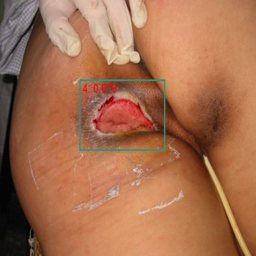

In [9]:
SZ = 256
ry = Image.new("RGB",(SZ,SZ),(255,0,0))
fr = Image.new("RGB",(SZ,SZ),(255,255,0))
hs = Image.new("RGB",(SZ,SZ),(0,0,255))
tissue = {7:hs, 8:fr, 9:ry}
img_out = draw_bbox(image,out).resize((SZ,SZ))


for i,t in enumerate(good_labels):
    mask = batch2pil(((good_masks[i])>0.5).float()).resize((SZ,SZ))
    mask = np.array(mask)*0.5
    mask = Image.fromarray(mask.astype('uint8')).convert('L')
    img_out = Image.composite(tissue[t.item()], img_out, mask)
    
img_out

In [63]:
# draw_bbox(image,out).resize((256,256))
# batch2pil(((good_masks[1])>0.5).float()).resize((256,256))

### Batch Eval 计算分数

In [1]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
from tqdm import tqdm
import voc_eval
import os

detpath = 'temp/det_outs.txt'
imgsetfile = 'temp/evallist.txt'

In [2]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1)
ds = dm.val_dataloader().dataset
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/d943453c13254916a4bc0765d150437f/checkpoints/epoch=21.ckpt')
net = model.net
net.eval()
pass

In [3]:
# 预测
outs = []
for image,target in tqdm(ds):
    out = net([image],[target])[0]
    outs += out2detfile(target,out)        

  0%|          | 0/100 [00:00<?, ?it/s]/home/zrway/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


In [ ]:
# 将检测结果写入文件

os.remove(detpath)
for i in outs:
    with open(detpath,'a+') as f:
        f.write(i)

In [ ]:
# 预测文件列表

os.remove(imgsetfile)
for _,target in ds:
    fname= target['fname']
    with open(imgsetfile,'a+') as f:
        f.write(fname +'\n')

In [28]:
voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  '深部组织损伤',
                  ovthresh=0.3,
                  use_07_metric=True)

100 annotationd have been read
tp: [1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] fp: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]


(array([0.07692308, 0.15384615, 0.23076923, 0.30769231, 0.30769231,
        0.38461538, 0.46153846, 0.46153846, 0.46153846, 0.46153846,
        0.46153846, 0.46153846, 0.53846154, 0.53846154, 0.53846154,
        0.53846154, 0.61538462]),
 array([1.        , 1.        , 1.        , 1.        , 0.8       ,
        0.83333333, 0.85714286, 0.75      , 0.66666667, 0.6       ,
        0.54545455, 0.5       , 0.53846154, 0.5       , 0.46666667,
        0.4375    , 0.47058824]),
 0.5332902391725921)

In [8]:
tissus_name = ['1期','2期','3期','4期','不可分期','深部组织损伤']
mAP = []
for i in tissus_name:
    ap = voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  i,
                  ovthresh=0.3,
                  use_07_metric=True)[-1]
    print(ap)
    mAP.append(ap)
sum(mAP)/len(mAP)

0.0
0.5424242424242423
0.4049586776859504
0.755058590834453
0.622854157336916
0.5332902391725921


0.4764309845756922